<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

---
    Mubina | Wei Hua | Liubin    

# Part 4: Model Evaluation, Conclusion, Cost Benefit analysis and Recommendations 

For this notebook, we will be evaluating the following models:
1. Logistic regression
2. KNN classifier 
3. Random Forest classifier 

Dataset with moving average and time lagged weather features based on the nearest weather station will be used for evaluation. 

The metrics used for model performance evaluation will be ROC AUC score and the recall score. 

In this section, we will also be covering conclusion, cost benefit analysis and recommendation. 

### Contents:
> 1. [Model Evaluation](#1.-Model-Evaluation)
> 2. [Conclusion](#2.-Conclusion)
> 3. [Cost Benefit Analysis](#3.-Cost-Benefit-Analysis)
> 4. [Recommendations](#4.-Recommendations)


In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import geopy.distance


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, auc, roc_curve, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import pickle

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Model Evaluation

Dataset to be used for evaluation: 

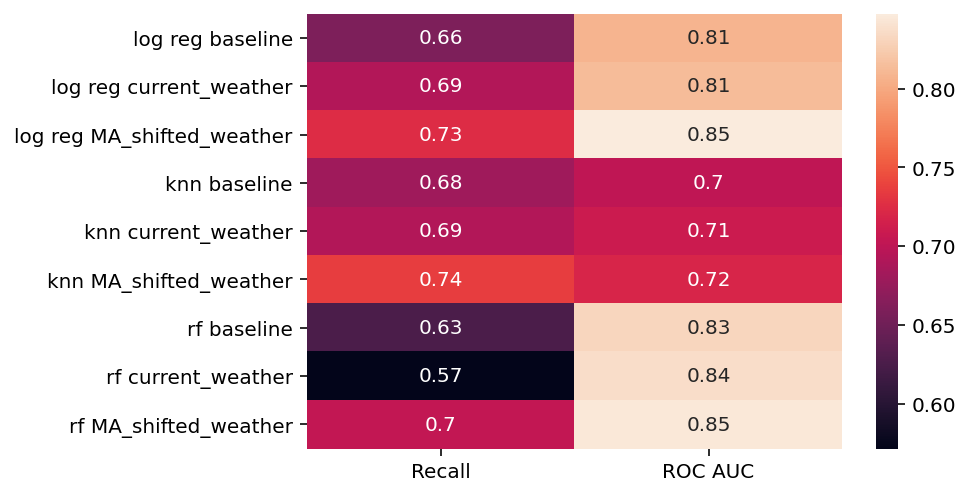

In general, shifted weather dataset gives a higher score for ROC AUC score for the 3 models and hence we will be using shifted weather dataset for evaluation. 

In [2]:
# import dataframes
train_wlag = pd.read_csv('../models/train_wlag.csv')
datasets = {'MA_shifted_weather':train_wlag}

In [3]:
# import models 
lr = pickle.load(open('../models/logreg.pkl', 'rb'))
knn = pickle.load(open('../models/knn.pkl', 'rb'))
rf = pickle.load(open('../models/rf.pkl', 'rb'))

In [4]:
# define functions for modeling

# compare recall scores
def display_recall(model, X_train, y_train, X_test, y_test):
    print('Train Recall: ', round(recall_score(y_train, model.predict(X_train)),5))
    print('Test Recall: ', round(recall_score(y_test, model.predict(X_test)),5))
    print('Cross Val train roc_auc:', round(cross_val_score(model, X_train,y_train, scoring = 'roc_auc',cv=5).mean(),5))
    print('Cross Val test roc_auc:', round(cross_val_score(model, X_test,y_test, scoring = 'roc_auc',cv=5).mean(),5))
    
# plot ROC and Confusion matrix
def plot_model(model, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot ROC curve
    ax1.set_title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax = ax1)
    ax1.plot([0, 1], [0, 1],label='baseline', linestyle='--')
    ax1.legend()

    #Plot confusion matrix
    ax2.set_title('Confusion Matrix')
    y_labeled = y_test.map({1:'WNV Present', 0:'WNV Not Present'})
    y_pred = pd.Series(model.predict(X_test)).map({1:'WNV Present', 0:'WNV Not Present'})
    cm = confusion_matrix(y_labeled, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax2, cmap='Blues')
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    ax2.xaxis.set_ticklabels(['WNV Present', 'WNV Not Present']) 
    ax2.yaxis.set_ticklabels(['WNV Present', 'WNV Not Present'])
    plt.show();

# model comparisons
model_dictionary = {}
def add_model(name, model, X_test, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    model_dictionary[name] = [round(recall_score(y_test, model.predict(X_test)),3), #Recall 
                              round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3), #ROC AUC 
                              tp, #True Positive
                              fp, #False Positive
                              tn, #True Negative
                              fn #False Negative
                             ]
    return model_dictionary

In [5]:
# function to run all 3 datasets through one model
def run_datasets(name,gs_model):
    
    data = datasets.copy()
    for jj in datasets:
        data[jj] = datasets[jj].drop('date', axis = 1)
        Xtrain,Xtest,ytrain,ytest=train_test_split(data[jj].drop('wnvpresent',1),data[jj]['wnvpresent'],test_size=0.2,random_state=42,stratify=data[jj]['wnvpresent'])
        print(jj)
        print('Xtrain',Xtrain.shape)
        print('Xtest',Xtest.shape)
        
        #scale
        ss = StandardScaler()
        Xs_train = ss.fit_transform(Xtrain)
        Xs_test = ss.transform(Xtest)
        
        #smote
        smt=SMOTE(random_state=42)
        Xsm_train,ysm_train=smt.fit_resample(Xs_train,ytrain)
        
        #fit model
        gs_model.fit(Xsm_train, ysm_train)
        
        #print best parameters
        display_recall(gs_model, Xsm_train, ysm_train, Xs_test, ytest)
        plot_model(gs_model, Xs_test, ytest)
        model_name = name + ' ' + jj
        add_model(model_name, gs_model, Xs_test, ytest)

In [6]:
def compare_models():
    return pd.DataFrame.from_dict(model_dictionary, 
                                  orient = 'index', 
                                  columns=['Recall', 'ROC AUC', 'True Positives', 'False Positives','True Negatives','False Negatives'])

### 1.1  Logistic Regression

MA_shifted_weather
Xtrain (6780, 624)
Xtest (1695, 624)
Train Recall:  0.92813
Test Recall:  0.72527
Cross Val train roc_auc: 0.92696
Cross Val test roc_auc: 0.78735


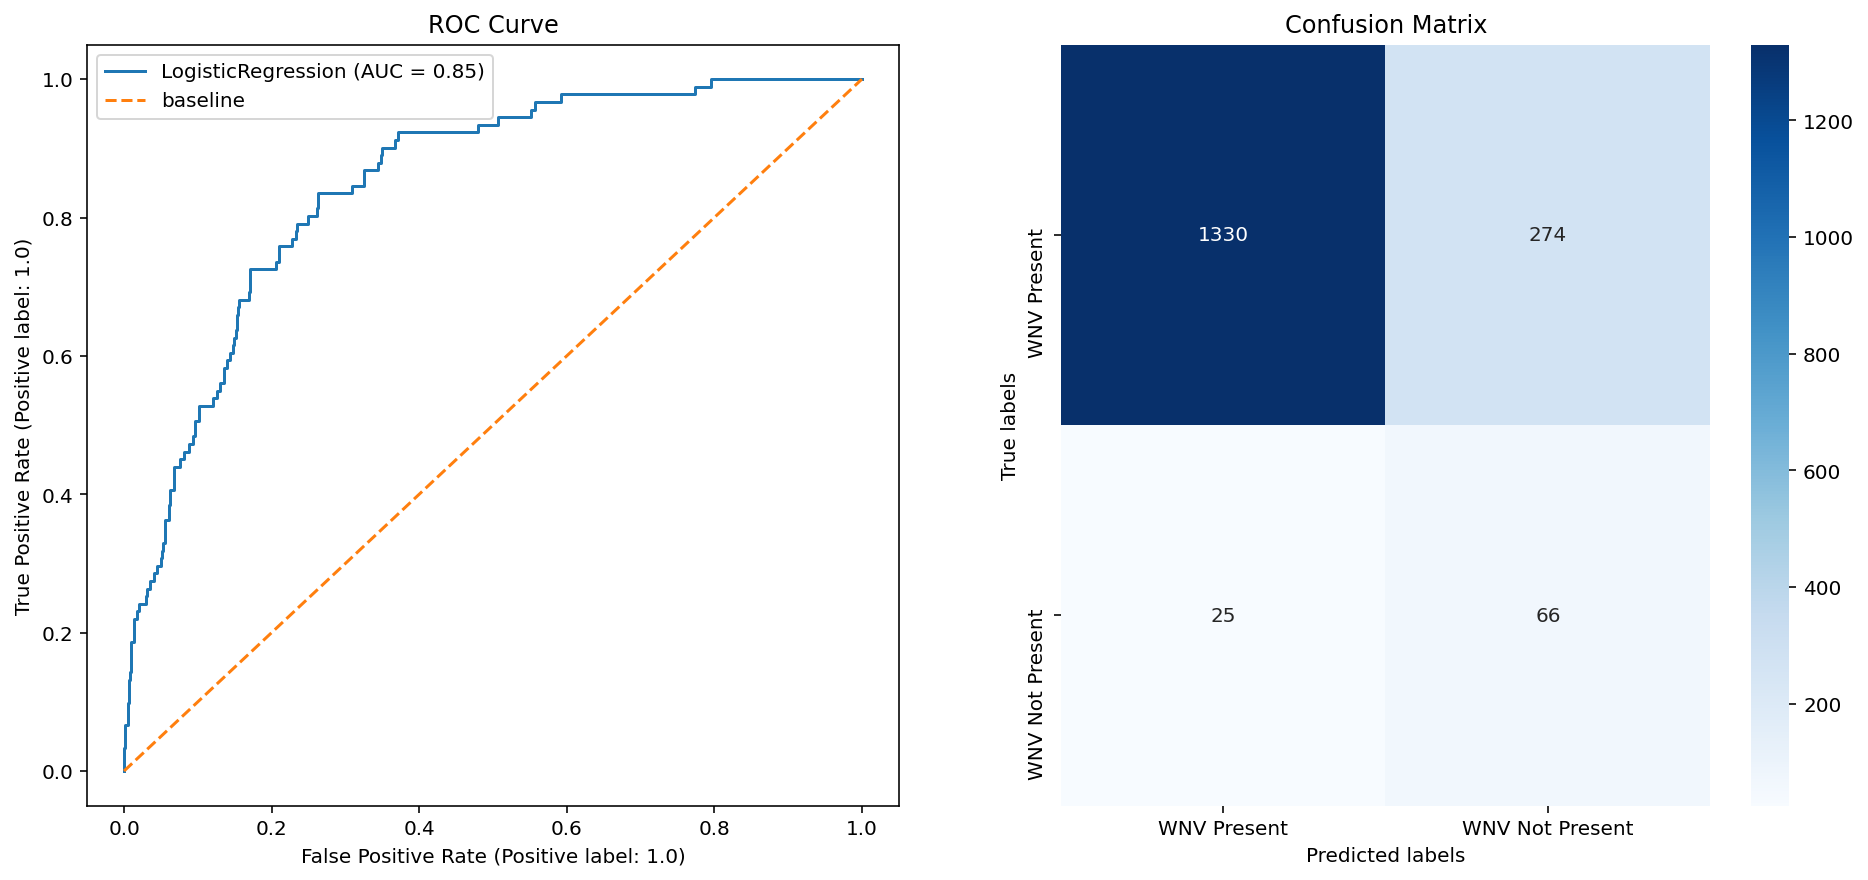

In [7]:
run_datasets('log reg', lr)

In [8]:
compare_models()

,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
log reg MA_shifted_weather,0.725,0.848,66,274,1330,25


### 1.2 KNN classifier

MA_shifted_weather
Xtrain (6780, 624)
Xtest (1695, 624)
Train Recall:  0.99782
Test Recall:  0.73626
Cross Val train roc_auc: 0.94013
Cross Val test roc_auc: 0.74227


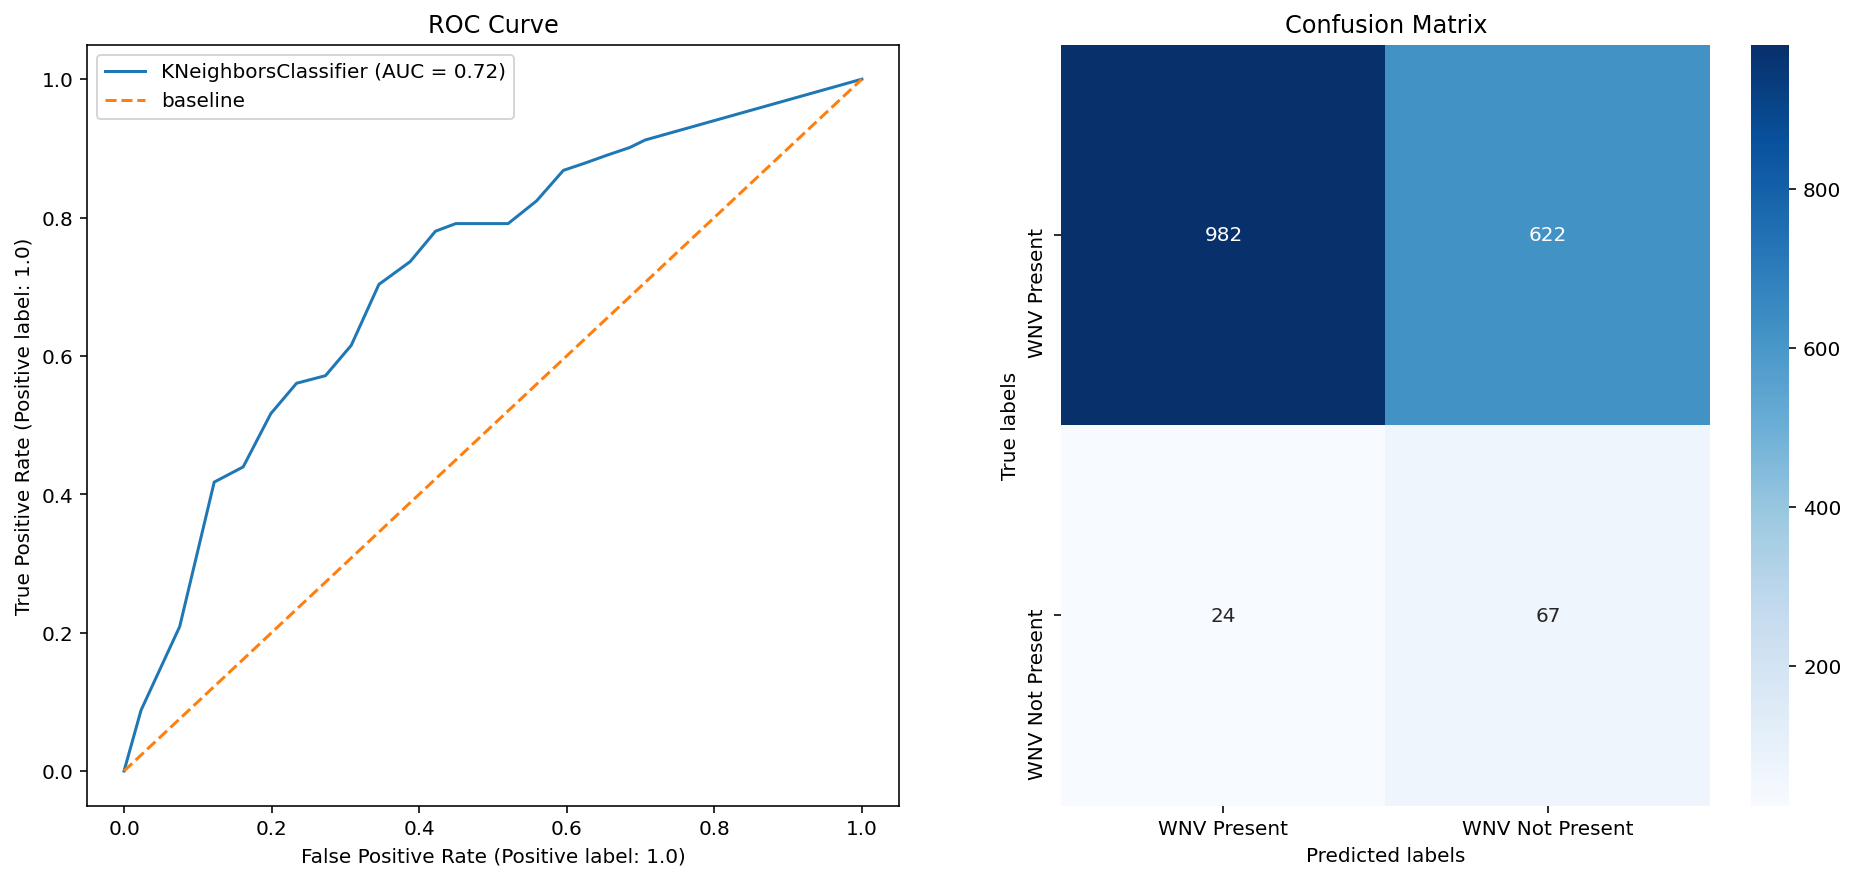

In [9]:
run_datasets('knn', knn)

In [10]:
compare_models()

,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
log reg MA_shifted_weather,0.725,0.848,66,274,1330,25
knn MA_shifted_weather,0.736,0.720,67,622,982,24


### 1.3 Random Forest Classifier

MA_shifted_weather
Xtrain (6780, 624)
Xtest (1695, 624)
Train Recall:  0.96367
Test Recall:  0.74725
Cross Val train roc_auc: 0.95308
Cross Val test roc_auc: 0.83124


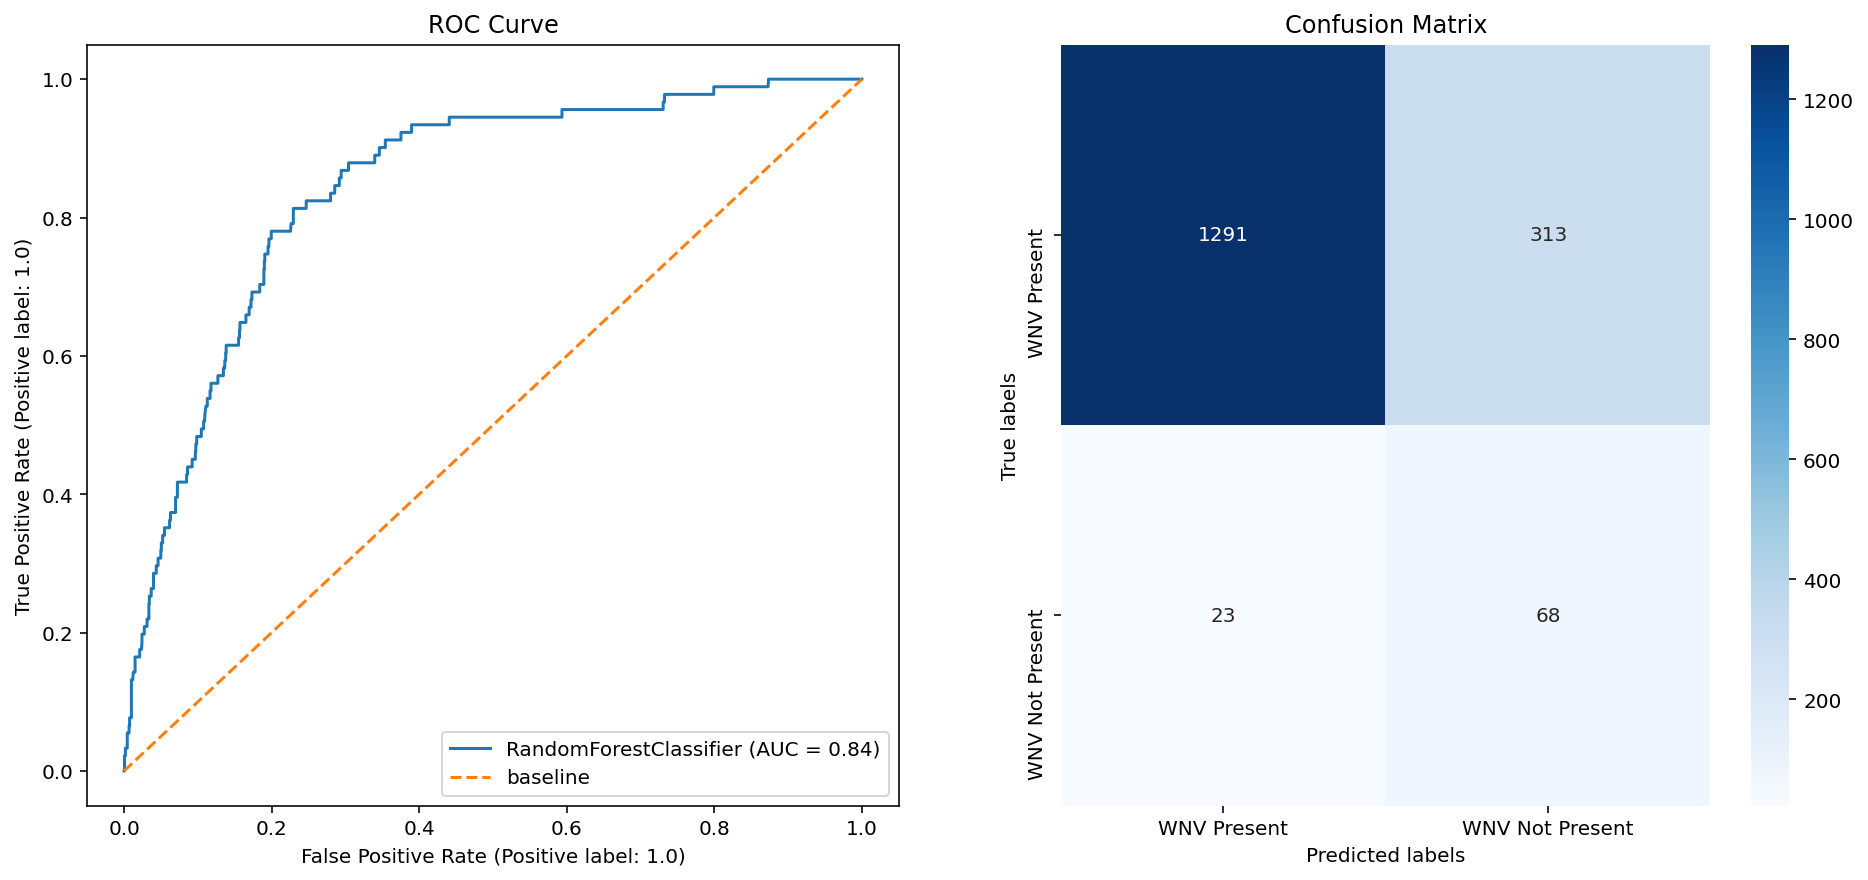

In [11]:
run_datasets('rf', rf)

In [12]:
compare_models()

,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
log reg MA_shifted_weather,0.725,0.848,66,274,1330,25
knn MA_shifted_weather,0.736,0.720,67,622,982,24
rf MA_shifted_weather,0.747,0.844,68,313,1291,23


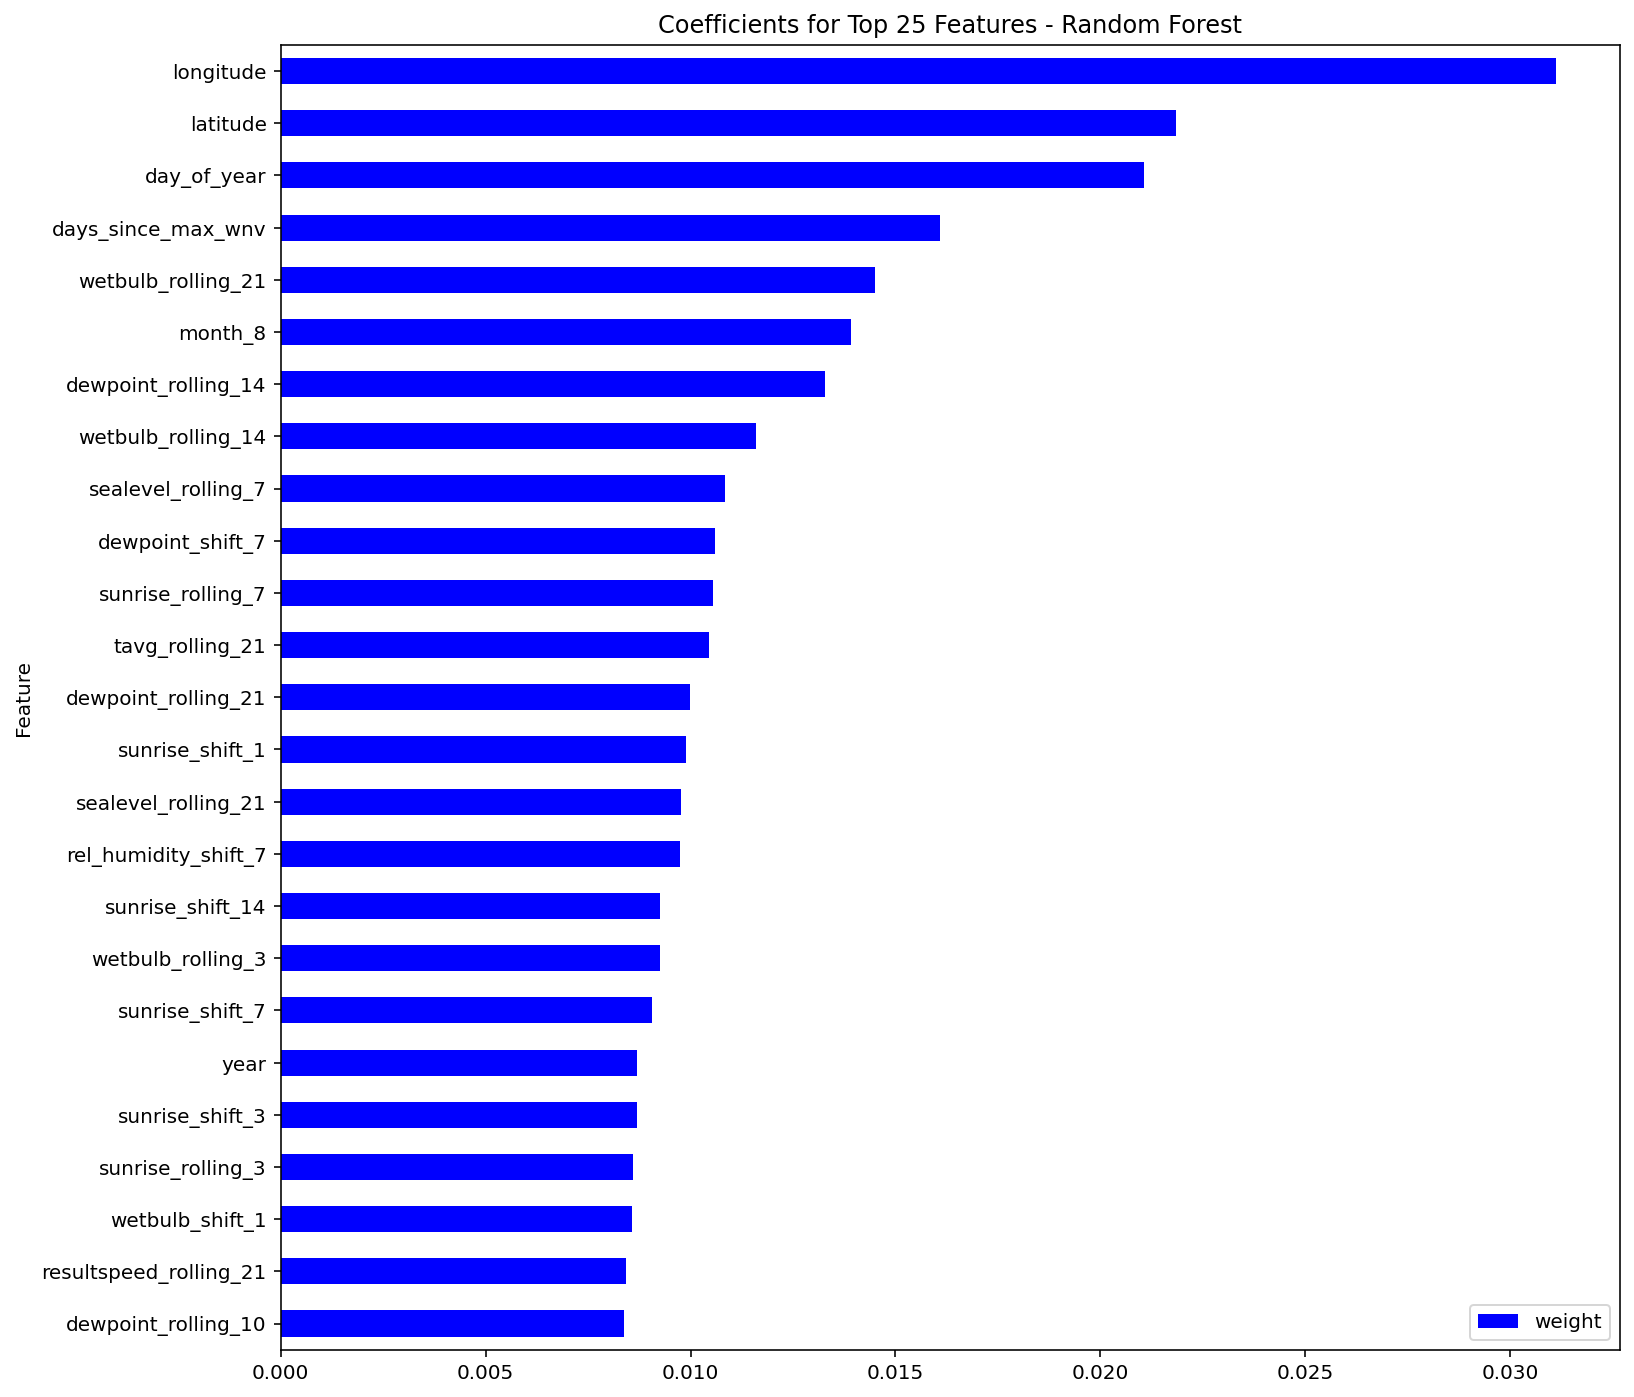

Observations: 
- In general, models performed better with moving average and time lagged dataset. 
- All models are overfitting. It could be due to the imbalance dataset. 
- SMOTE is being used to handle imbalance dataset.
- All 3 models have their hyperparameter tuned:
    + Logistic Regression - C 
    + KNN classifier - n_neighbours
    + Random Forest Classifier - n_estimators,max_features, min_samples_leaf, max_depth
- Random Forest classifier is able to achieve the lowest False negatives with the highest recall score. 
- Hence, Random Forest Classifier perform the best followed by logistic regression and knn classifier. 
- The top 3 features identified by the model are longtitude, days since wnv present and day of the year

## 2. Conclusion

Synthetic Minority Oversampling Technic (SMOTE) is used on train data to avoid leakage of similar fabricated observations both in the train and the test, this helps to avoid overfitting. 

The target variable is imbalanced as only 5% of the cases has west nile virus. Hence, it is unreliable to compare the model's performance based on accuracy. 

The metrics used for evaluating the model will be : 
1. AUC-ROC score is a metric used for binary classification problems. The higher the AUC score, the better the performance of the model at distinguishing between the positive and negative classes. 
2. Recall score is score for true positive within all actual positive values which include False negative. False negative is the component that we want to reduce as the virus is deadly. 

Random Forest classifier is the best model because:
1. Least cross validation score difference of 12% even though the model is still overfitting. 
2. Highest recall score with the least False Negatives. False negative is important as we have to identify potential locations before it leads to a big outbreak of virus. 
3. Achieve similar ROC AUC score for logistic regression and random forest classifier. 

In conclusion, random forest classifier has ROC AUC score of 84% and recall score of 75%. With the classification model, it can be used to reduce false negative which means less positive case are identify as negative. 

The top features identified are mainly location, period of the year and weather conditions. 
1. Location-longitude and latitude
2. Days since max wnv present, day of the year and August
3. Wetbulb temperature, sealevel and dewpoint

The benefit of the model will be: 
1. CDC (primary stakeholder) can have a planning and optimisation of the spray process.
2. The public (Secondary Stakeholder) will feel secured and increased productivity as lesser people fall sick. 

## 3. Cost Benefit Analysis

In [13]:
# let's visualise the location prediction using the model 
# load test and pred data 
rf_pred = pd.read_csv('../models/kaggle/rf_pred.csv')
test = pd.read_csv('../assets/test_cleaned.csv')

# Merge both data set - test and pred
rf_data=pd.concat([rf_pred,test],axis = 1)

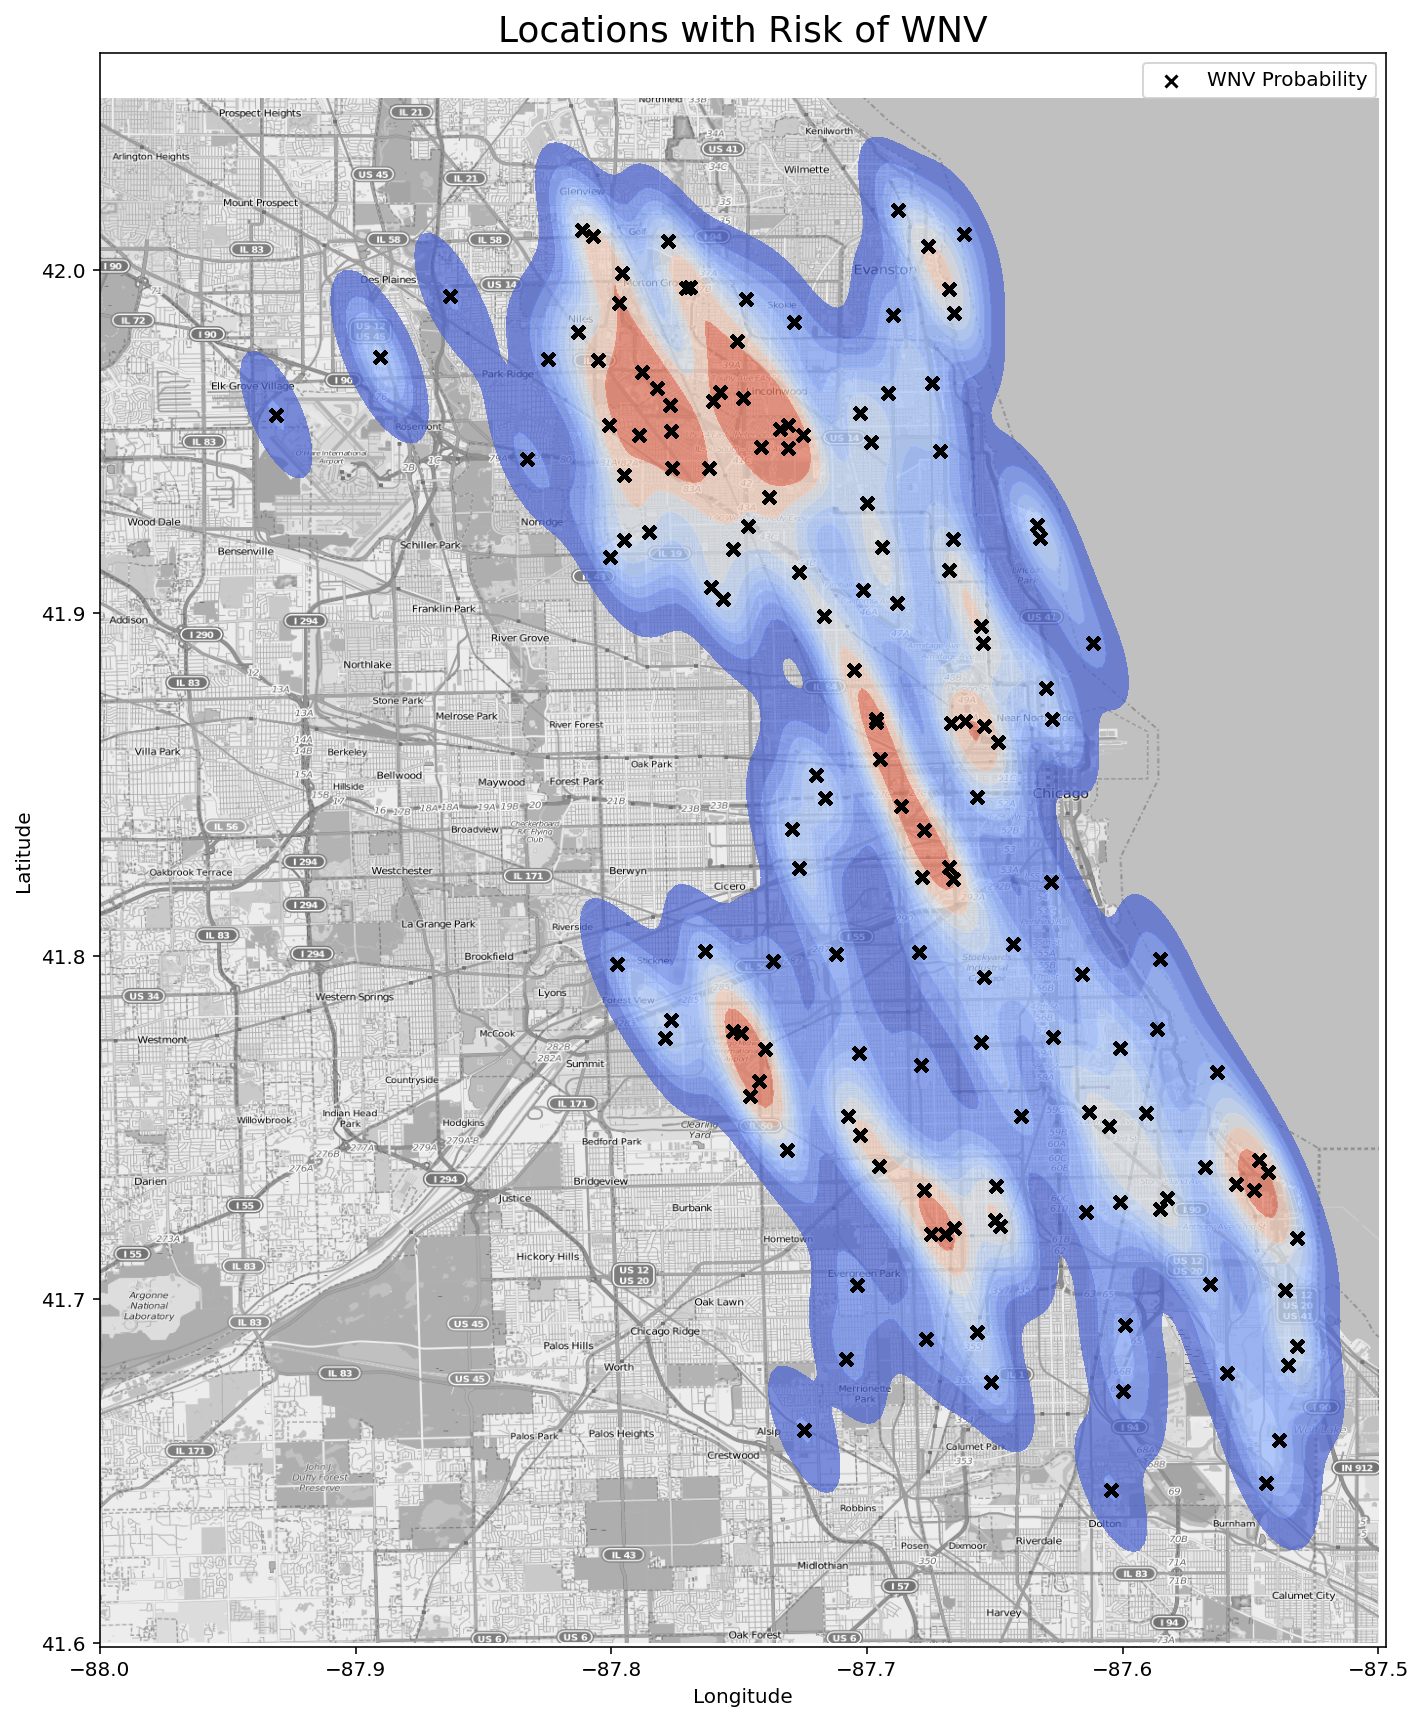

In [14]:
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.05)

plt.figure(figsize=(10,16))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# KDE plot of all predicted cases
sns.kdeplot(data=rf_data, x='longitude', y='latitude', fill=True, cmap='coolwarm', alpha = 0.7)

# Plot very high probability
plt.scatter(data=rf_data[rf_data['WnvPresent']!=0], x='longitude', y='latitude', marker='x', 
            color='black', label='WNV Probability')

plt.title('Locations with Risk of WNV', fontsize=18)
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

As shown in the map, the potential of west nile virus present is a widely spread across Chicago with the north side of the city being the worst. 

It was reported in the HealthDay News that West Nile virus-related hospitalization and follow ups in United States cost about USD 778 million in health care expenses and lost productivity from 1999 to 2012. This works out to about USD 56 million per year. 
(source: https://www.medicinenet.com/script/main/art.asp?articlekey=176668)

Taking referece to West Nile virus outbreak in Sacramento Country California in 2005, the table below shows the economic cost analysis for Chicago. (source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)

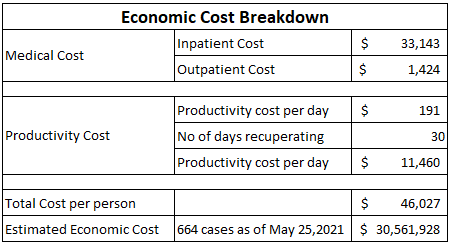

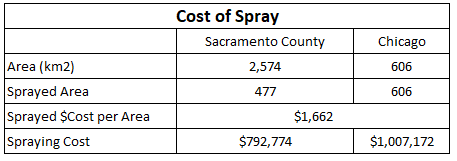

In summary, it is more economical to spray the whole city with pesticides in order to prevent any potential west nile virus outbreak. 
<br>
Benefits from mosquito spraying would include increased quality of life from fewer people falling sick and fatalities, increased workplace productivity by reducing the number of people falling sick, as well as savings in hospital expenses from treating WNV patients. Of these, only the latter two are calculated as shown in the table above. 

With the help of the model, we found that WNV is more prevalent under certain conditions. Location - longtitude and latitude was the top predictor, followed by day of year, days since maximum WNV, 21-days rolling mean of wet bulb temperature, August, and 14-days rolling mean of dewpoint. This means that WNV is most likely to occur in the North of Chicago especially in August and this is where and when spray efforts should be prioritised to maximise the benefit of the pesticide spray.  

Our team also suggested that educating the public on prevention of breeding mosquitoes is better than cure. We can implement it as part of the school education and put up more posters for awareness. The best way to prevent mosquitoes breeding is to avoid stagnant water.

## 4. Recommendations

The following are some recommendations for reducing the spread of West Nile virus: 
1. To take into consideration of the inhabitants population density of the areas
2. To make preventive measures on time such as periodic spray
3. To educate the public not to leave exposed stagnant water for mosquitoes to breed
4. To promote the use of insect repellent 
5. Prioritise spraying of pesticides in the North in August

As for the prediction model, we hoped to improve the model by :
1. To collect more data to have a more balance dataset
2. To reduce noise by reducing unimportant features
3. To better understand the impact of environment to the number of mosquitoes by having lesser missing data
4. To collect more recent data for better predictions